## Laboratorium PRiAD ##

# Projekt: Klasyfikacja wniosków kredytowych #

### Konrad Trusiewicz, Antoni Olszewski###
#### 01.02.2022 ####

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.3f}".format

In [3]:
df = pd.read_csv('crx.data', header=None, names=['Płeć','Wiek','Zadłużenie','Stan_cywilny','Bank','Wykształcenie','Pochodzenie','Lata_pracy','Poz_hist_kred','Umowa_o_pracę','Score_kredytowy','Prawo_jazdy','Obywatelstwo','Saldo_konta','Przychody','Wynik'], decimal='.', na_values='?', dtype = {'Płeć':'category','Stan_cywilny':'category','Bank':'category','Wykształcenie':'category','Pochodzenie':'category','Poz_hist_kred':'category','Umowa_o_pracę':'category','Prawo_jazdy':'category','Obywatelstwo':'category','Wynik':'category'})

Na początku wczytaliśmy biblioteki i plik z bazą danych pobraną z https://archive.ics.uci.edu/ml/datasets/Credit+Approval Nadaliśmy poszczególnym kolumnom rodzaj i nazwy. 

In [4]:
df.head()

,Płeć,Wiek,Zadłużenie,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Lata_pracy,Poz_hist_kred,Umowa_o_pracę,Score_kredytowy,Prawo_jazdy,Obywatelstwo,Saldo_konta,Przychody,Wynik
0,b,30.830,0.000,u,g,w,v,1.250,t,t,1,f,g,202.000,0,+
1,a,58.670,4.460,u,g,q,h,3.040,t,t,6,f,g,43.000,560,+
2,a,24.500,0.500,u,g,q,h,1.500,t,f,0,f,g,280.000,824,+
3,b,27.830,1.540,u,g,w,v,3.750,t,t,5,t,g,100.000,3,+
4,b,20.170,5.625,u,g,w,v,1.710,t,f,0,f,s,120.000,0,+


In [5]:
print(str(df.shape[0]) + ' wierszy.')
print(str(df.shape[1]) + ' kolumn.')

690 wierszy.
16 kolumn.


In [6]:
df.dropna(inplace=True)

In [7]:
print(str(df.shape[0]) + ' wierszy.')
print(str(df.shape[1]) + ' kolumn.')

653 wierszy.
16 kolumn.


Zliczyliśmy liczbę kolumn i wierszy. Później usunęliśmy wiersze z brakującymi danymi - zostało usuniętych 37 wierszy.

In [8]:
df.select_dtypes(exclude = ['int64', 'float64']).describe()

,Płeć,Stan_cywilny,Bank,Wykształcenie,Pochodzenie,Poz_hist_kred,Umowa_o_pracę,Prawo_jazdy,Obywatelstwo,Wynik
count,653,653,653,653,653,653,653,653,653,653
unique,2,3,3,14,9,2,2,2,3,2
top,b,u,g,c,v,t,f,f,g,-
freq,450,499,499,133,381,349,366,351,598,357


Wyświetliliśmy wszystkie atrybuty z rodzajem category. Możemy tu zacząc wstępna analizę atrybutów. Jak widzimy atrybuty Płeć, Poz_hist_kred, Umowa_o_pracę, Prawo_jazdy i Wynik maja tylko po 2 unikalne argumenty. Będziemy mogli dzięki temu później zamienić ich typy na binarne, co pomoże nam w klasyfikacji danych. 

In [9]:
df.select_dtypes(include = ['int64', 'float64']).describe()

,Wiek,Zadłużenie,Lata_pracy,Score_kredytowy,Saldo_konta,Przychody
count,653.000,653.000,653.000,653.000,653.000,653.000
mean,31.504,4.830,2.244,2.502,180.360,1013.761
std,11.838,5.027,3.371,4.968,168.297,5253.279
min,13.750,0.000,0.000,0.000,0.000,0.000
25%,22.580,1.040,0.165,0.000,73.000,0.000
50%,28.420,2.835,1.000,0.000,160.000,5.000
75%,38.250,7.500,2.625,3.000,272.000,400.000
max,76.750,28.000,28.500,67.000,2000.000,100000.000


In [10]:
df.Poz_hist_kred.replace(['t','f'],[1,0], inplace=True)
df.Umowa_o_pracę.replace(['t','f'],[1,0], inplace=True)
df.Płeć.replace(['a','b'],[1,0], inplace=True)
df.Prawo_jazdy.replace(['t','f'],[1,0], inplace=True)
df.Wynik.replace(['+','-'],[1,0], inplace=True)

df['Poz_hist_kred'] = df['Poz_hist_kred'].astype('uint8')
df['Umowa_o_pracę'] = df['Umowa_o_pracę'].astype('uint8')
df['Płeć'] = df['Płeć'].astype('uint8')
df['Prawo_jazdy'] = df['Prawo_jazdy'].astype('uint8')
df['Wynik'] = df['Wynik'].astype('uint8')

Zamieniamy atrybuty o których wspomnieliśmy wcześniej na rodzaj binarny.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Płeć             653 non-null    uint8   
 1   Wiek             653 non-null    float64 
 2   Zadłużenie       653 non-null    float64 
 3   Stan_cywilny     653 non-null    category
 4   Bank             653 non-null    category
 5   Wykształcenie    653 non-null    category
 6   Pochodzenie      653 non-null    category
 7   Lata_pracy       653 non-null    float64 
 8   Poz_hist_kred    653 non-null    uint8   
 9   Umowa_o_pracę    653 non-null    uint8   
 10  Score_kredytowy  653 non-null    int64   
 11  Prawo_jazdy      653 non-null    uint8   
 12  Obywatelstwo     653 non-null    category
 13  Saldo_konta      653 non-null    float64 
 14  Przychody        653 non-null    int64   
 15  Wynik            653 non-null    uint8   
dtypes: category(5), float64(4), int64(2), uint8(

In [12]:
cat = pd.DataFrame(df.Stan_cywilny.value_counts())
cat.rename(columns={'Stan_cywilny':'Num_of_obs'}, inplace=True)
cat['Per_of_obs'] = cat['Num_of_obs']/df.shape[0]*100
print(cat)
print('Crosstab:')
pd.crosstab(df.Stan_cywilny, df.Wynik)

   Num_of_obs  Per_of_obs
u         499      76.417
y         152      23.277
l           2       0.306
Crosstab:


Wynik,0,1
Stan_cywilny,,
l,0,2
u,250,249
y,107,45


In [13]:
cat = pd.DataFrame(df.Bank.value_counts())
cat.rename(columns={'Bank':'Num_of_obs'}, inplace=True)
cat['Per_of_obs'] = cat['Num_of_obs']/df.shape[0]*100
print(cat)
print('Crosstab:')
pd.crosstab(df.Bank, df.Wynik)

    Num_of_obs  Per_of_obs
g          499      76.417
p          152      23.277
gg           2       0.306
Crosstab:


Wynik,0,1
Bank,,
g,250,249
gg,0,2
p,107,45


In [14]:
df.groupby(['Bank', 'Stan_cywilny'])['Wynik'].describe()

,,count,mean,std,min,25%,50%,75%,max
Bank,Stan_cywilny,,,,,,,,
g,u,499.000,0.499,0.501,0.000,0.000,0.000,1.000,1.000
gg,l,2.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
p,y,152.000,0.296,0.458,0.000,0.000,0.000,1.000,1.000


Przy analizie danych zauważyliśmy, że atrybuty 'Bank' oraz 'Stan cywilny' są sobie równe. Może to być jakiś błąd w bazie danych lub nie, w każdym bądź razie postanowiliśmy usunąć jeden z atrybutów.

In [15]:
df = df.drop(columns = ['Stan_cywilny'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Płeć             653 non-null    uint8   
 1   Wiek             653 non-null    float64 
 2   Zadłużenie       653 non-null    float64 
 3   Bank             653 non-null    category
 4   Wykształcenie    653 non-null    category
 5   Pochodzenie      653 non-null    category
 6   Lata_pracy       653 non-null    float64 
 7   Poz_hist_kred    653 non-null    uint8   
 8   Umowa_o_pracę    653 non-null    uint8   
 9   Score_kredytowy  653 non-null    int64   
 10  Prawo_jazdy      653 non-null    uint8   
 11  Obywatelstwo     653 non-null    category
 12  Saldo_konta      653 non-null    float64 
 13  Przychody        653 non-null    int64   
 14  Wynik            653 non-null    uint8   
dtypes: category(4), float64(4), int64(2), uint8(5)
memory usage: 42.7 KB


Do klasyfikacji wybraliśmy model lasu losowego. By ułatwić klasyfikacje postanowilismy rozdzielić wszystkie atrybuty kategoryczne na ich binarne odpowiedniki za pomocą metody get_dummies. Później rozpoczeliśmy klasyfikacje.

In [17]:
df = pd.concat([df,pd.get_dummies(df.Bank, prefix='Bank__')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Wykształcenie, prefix='Wykształcenie__')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Pochodzenie, prefix='Pochodzenie__')], axis = 1)
df = pd.concat([df,pd.get_dummies(df.Obywatelstwo, prefix='Obywatelstwo__')], axis = 1)

df.drop(['Bank', 'Wykształcenie', 'Pochodzenie', 'Obywatelstwo'], axis = 1, inplace = True)

In [18]:
x = df.drop(columns=['Wynik'])
y = df['Wynik']

In [19]:
#from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100, random_state=17)

accuracy = 0
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17*i)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy/100)

Accuracy:  0.8764285714285716


Tu mamy wynik naszej pierwszej klasyfikacji, do której użyliśmy wszystkich atrybutów.

In [20]:
columns = x.columns
feature_imp = pd.Series(clf.feature_importances_,index=columns).sort_values(ascending=False)
feature_imp

Poz_hist_kred        0.298
Lata_pracy           0.096
Przychody            0.087
Score_kredytowy      0.083
Zadłużenie           0.072
Saldo_konta          0.066
Wiek                 0.060
Umowa_o_pracę        0.047
Bank___g             0.012
Płeć                 0.012
Prawo_jazdy          0.012
Wykształcenie___q    0.012
Bank___p             0.011
Wykształcenie___x    0.010
Wykształcenie___c    0.010
Wykształcenie___k    0.010
Pochodzenie___h      0.009
Wykształcenie___w    0.009
Pochodzenie___v      0.008
Wykształcenie___ff   0.008
Wykształcenie___i    0.008
Pochodzenie___ff     0.007
Wykształcenie___cc   0.007
Obywatelstwo___g     0.007
Obywatelstwo___s     0.006
Wykształcenie___e    0.006
Pochodzenie___bb     0.005
Pochodzenie___n      0.005
Wykształcenie___m    0.004
Wykształcenie___aa   0.004
Wykształcenie___d    0.004
Pochodzenie___j      0.002
Bank___gg            0.002
Pochodzenie___dd     0.001
Pochodzenie___z      0.001
Wykształcenie___j    0.001
Pochodzenie___o      0.000
W

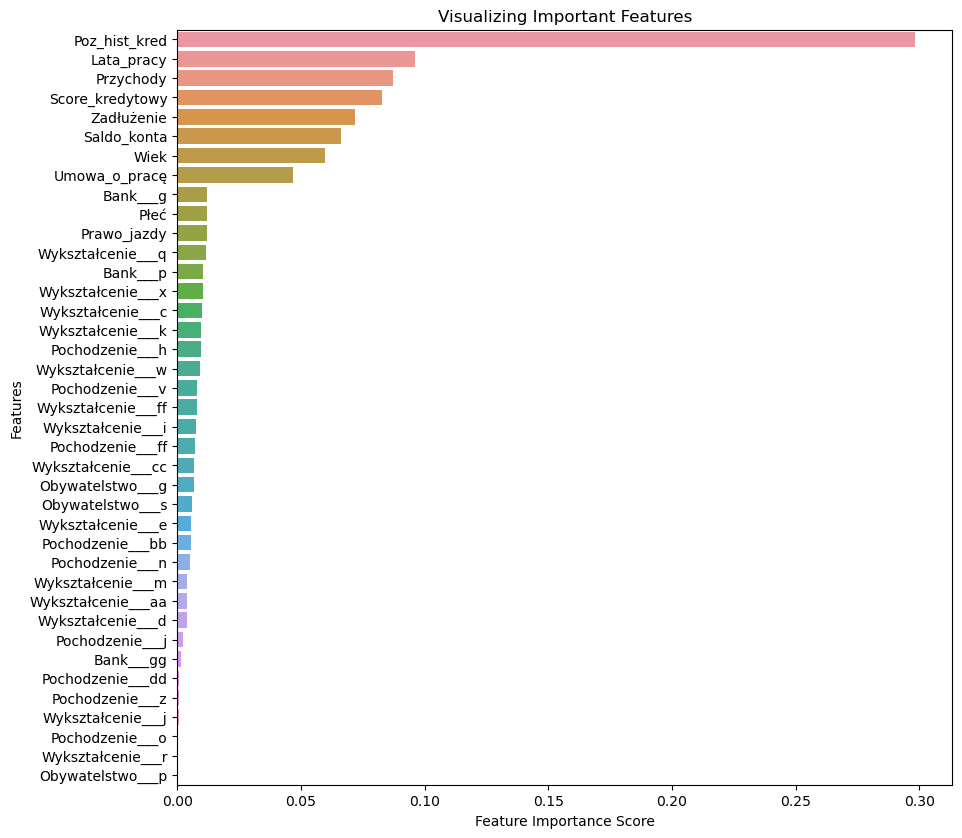

In [21]:
%matplotlib inline
plt.figure(figsize=(10,10),dpi = 100)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Tutaj wyświetliliśmy jak duże znaczenie w klasyfikacji mają poszczególne atrybuty. Postanowiliśmy sprawdzić jak będzie zmieniała się dokładność naszej klasyfikacji w zależności od liczby atrybutów użytych. Badania wykonaliśmy dla dwóch modeli klasyfikacji lasem losowym. W pierwszym, maksymalna liczba atrybutów jaką klasyfikator będzie używał w szukaniu najlepszego podziału w rozgałęzieniu drzewa w naszym lesie jest liczona za pomocą log2 (logartym o podstawie 2 z ilości wszystkich atrybutów), a w drugim jest to pierwiastek (z ilości wszystkich atrybutów). 

In [22]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Płeć                653 non-null    uint8  
 1   Wiek                653 non-null    float64
 2   Zadłużenie          653 non-null    float64
 3   Lata_pracy          653 non-null    float64
 4   Poz_hist_kred       653 non-null    uint8  
 5   Umowa_o_pracę       653 non-null    uint8  
 6   Score_kredytowy     653 non-null    int64  
 7   Prawo_jazdy         653 non-null    uint8  
 8   Saldo_konta         653 non-null    float64
 9   Przychody           653 non-null    int64  
 10  Bank___g            653 non-null    uint8  
 11  Bank___gg           653 non-null    uint8  
 12  Bank___p            653 non-null    uint8  
 13  Wykształcenie___aa  653 non-null    uint8  
 14  Wykształcenie___c   653 non-null    uint8  
 15  Wykształcenie___cc  653 non-null    uint8  
 16  Wykształ

In [23]:
features = []
features.append(feature_imp.index[0])
features.append(feature_imp.index[1])
features.append(feature_imp.index[2])
features.append(feature_imp.index[3])
y = df['Wynik']
clf=RandomForestClassifier(n_estimators=100, max_features='log2', random_state=17)
accuracy_log2 = []

for i in range(4,20):
    accuracy = 0
    features.append(feature_imp.index[i])
    x = df[features]
    for j in range(0,10):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17*j)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
    print(i+1, ' features')
    print('Accuracy: ', accuracy/10)
    accuracy_log2.append(accuracy/10)

5  features
Accuracy:  0.8642857142857144
6  features
Accuracy:  0.8841836734693876
7  features
Accuracy:  0.8806122448979592
8  features
Accuracy:  0.8775510204081632
9  features
Accuracy:  0.8811224489795917
10  features
Accuracy:  0.8831632653061223
11  features
Accuracy:  0.8862244897959183
12  features
Accuracy:  0.8846938775510204
13  features
Accuracy:  0.8806122448979593
14  features
Accuracy:  0.8857142857142858
15  features
Accuracy:  0.8831632653061223
16  features
Accuracy:  0.8826530612244898
17  features
Accuracy:  0.8770408163265306
18  features
Accuracy:  0.8841836734693878
19  features
Accuracy:  0.8811224489795919
20  features
Accuracy:  0.8816326530612246


In [24]:
features = []
features.append(feature_imp.index[0])
features.append(feature_imp.index[1])
features.append(feature_imp.index[2])
features.append(feature_imp.index[3])
y = df['Wynik']
clf=RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=17)
accuracy_sqrt = []

for i in range(4,20):
    accuracy = 0
    features.append(feature_imp.index[i])
    x = df[features]
    for j in range(0,10):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17*j)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
    print(i+1, ' features')
    print('Accuracy: ', accuracy/10)
    accuracy_sqrt.append(accuracy/10)

5  features
Accuracy:  0.8642857142857144
6  features
Accuracy:  0.8841836734693876
7  features
Accuracy:  0.8806122448979592
8  features
Accuracy:  0.8801020408163266
9  features
Accuracy:  0.8811224489795917
10  features
Accuracy:  0.8831632653061223
11  features
Accuracy:  0.8862244897959183
12  features
Accuracy:  0.8846938775510204
13  features
Accuracy:  0.8806122448979593
14  features
Accuracy:  0.8857142857142858
15  features
Accuracy:  0.8831632653061223
16  features
Accuracy:  0.8826530612244898
17  features
Accuracy:  0.8770408163265306
18  features
Accuracy:  0.8841836734693878
19  features
Accuracy:  0.8811224489795919
20  features
Accuracy:  0.8816326530612246


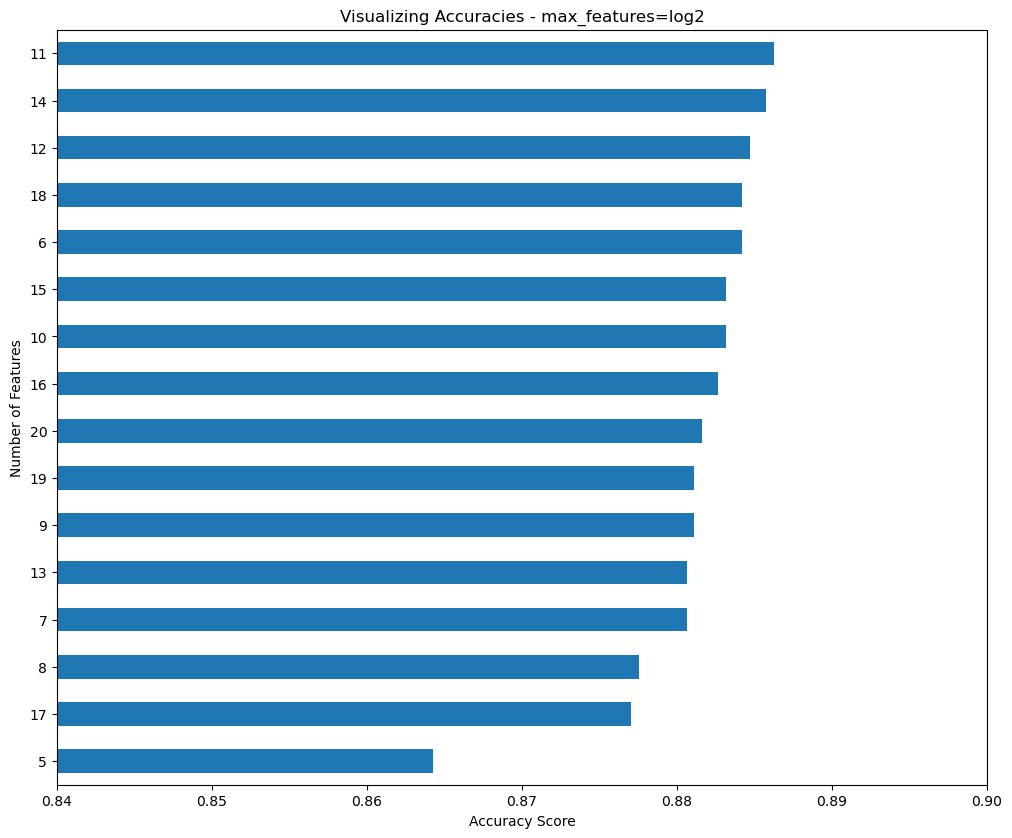

model log2, średnia dokładność:  0.8811224489795917


In [25]:
accuracy_log2 = pd.Series(accuracy_log2, index=range(5,21)).sort_values()

plt.figure(figsize=(12,10),dpi = 100)
accuracy_log2.plot(kind='barh',rot=0);
plt.xlim(0.84, 0.9)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Features')
plt.title("Visualizing Accuracies - max_features=log2")
plt.show()
print('model log2, średnia dokładność: ', accuracy_log2.mean())

W modelu log2 najlepszą dokładność osiągneliśmy przy 11 (0.8862) i 14 (0.8831) atrybutach. Jednak bez wzgledu na liczbę atrybutów, dokładność zawsze była dość wysoka - średnia dokładność = 0.8811 (najmniejsza była dla 5 atrybutów wynosiła 0.8642)

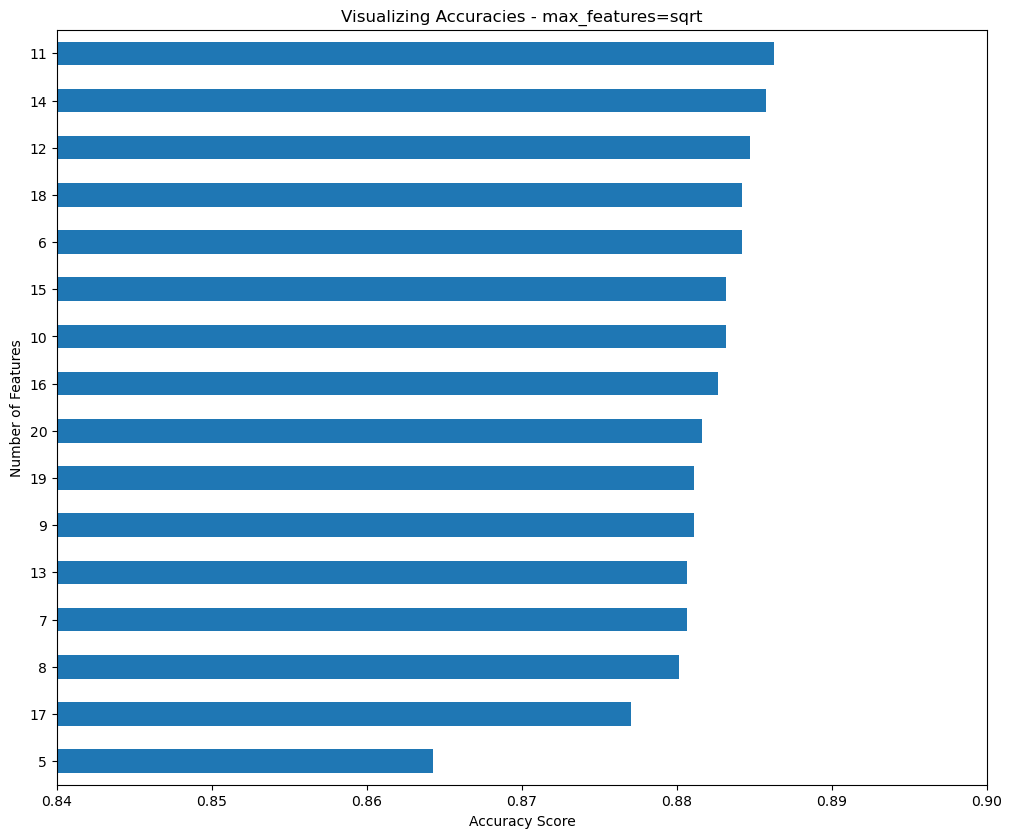

model sqrt, średnia dokładność:  0.8812818877551019


In [26]:
accuracy_sqrt = pd.Series(accuracy_sqrt, index=range(5,21)).sort_values()

plt.figure(figsize=(12,10),dpi = 100)
accuracy_sqrt.plot(kind='barh',rot=0);
plt.xlim(0.84, 0.9)
plt.xlabel('Accuracy Score')
plt.ylabel('Number of Features')
plt.title("Visualizing Accuracies - max_features=sqrt")
plt.show()
print('model sqrt, średnia dokładność: ', accuracy_sqrt.mean())

W modelu sqrt najlepszą dokładność osiągneliśmy przy 11 (0.8862) i 14 (0.8831) atrybutach. W tym modelu, w przypadku 5 atrybutów, dokładność osiągneła 0.8643 co jest dosć gorszym wynikiem niż reszta przypadków. Średnia dokładność: 0.8812

Modele log2 i sqrt, nie różnią się niczym z powodu 2 rzeczy:
* po pierwsze sqrt i log2 dla małych wartości są sobie praktycznie równe, więc liczba zmiennych wybieranych przez klasyfikatory jest taka sama w większości przypadków
* random_state jest ustawiony ten sam dla obu klasyfikatorów

In [30]:
x = df[['Poz_hist_kred', 'Score_kredytowy', 'Lata_pracy', 'Zadłużenie', 'Przychody', 'Wiek', 'Saldo_konta', 'Umowa_o_pracę']]
y = df['Wynik']
clf=RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=17)

accuracy = 0
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17*i)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy/100)

Accuracy:  0.8699999999999999


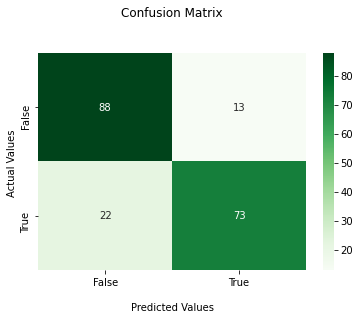

In [31]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, annot=True, cmap="Greens")

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Przykładowa macierz pomyłek dla lasu losowego (8 zmiennych, sqrt)

## Wnioski:
* Przy użyciu lasu losowego otrzymujemy dobrą dokładność dla klasyfikacji naszego zbioru
* Mimo wszystko nasza dokładność jest zbyt mała, żeby używać jej gdzieś profesjonalnie
* Może to wynikać z błędów w zbiorze uczącym
* Las losowy jest dość dobrym klasyfikatorem jeśli chodzi o ten zbiór: dobrze sobie radzi z dużą ilością cech
* W przeciwieństwie do drzewa decyzyjnego, lepiej unika dopasowania do zbioru uczącego
* Wszystkie nasze klasyfikacje (drzewa losowe) generowały 100 drzew
* Klasyfikacje dla klasyfikatorów z użyciem powyżej 5 atrybutów nie różniły się znacząco dokładnością
* W naszym zbiorze mamy 8 atrybutów bardziej znaczących niż reszta